In [1]:
import ipydeps
ipydeps.pip(['bs4', 'pandas','sklearn', 'pca', 'matplotlib', 'imblearn', 'plot_metric', 'pandas-profiling', 'ipywidgets'])

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests

from bs4 import BeautifulSoup
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from IPython.core.display import HTML
from ipywidgets import Layout
from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from pca import pca
from urllib.request import urlopen
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings(action='once')

# Main functions

In [59]:
def get_class_scatter(classes: dict, title='Data'):
    plt.figure(figsize=(8, 8), dpi=80)
    for label, _ in classes.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.title(f'{title}')
    plt.legend()
    plt.show()

    
def get_confusion_matrix(model, y_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
    
    disp.plot(cmap='Blues')
    plt.show()


def get_roc_graph(model, X_test, y_test, title='model'):
    
    model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=model_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f'{title} ROC')
    plt.show()


def get_nfl_team_data(teams: dict, time_period: list) -> list:
    # send requests to get data
    data_list = []
    index_cntr = 0
    for team in teams:
        for year in time_period:
            url = f'https://sports.core.api.espn.com/v2/sports/football/leagues/nfl/seasons/{year}/types/2/teams/{team["team_number"]}/statistics'
            try:
                r_data = requests.get(url).json()['splits']['categories']

                result ={'team': team['team_name']}
                stat_list = []
                for rec in r_data:
                    stats_data = rec['stats']
                    field_names, field_values = [] , []
                    for stats_rec in stats_data:
                        if stats_rec['name'].startswith(('passing','rushing', 'total')):
                            if 'totalGiveaways' not in stats_rec['name'] or 'totalTakeaways' not in stats_rec['name']:
                                stat_values = (stats_rec['name'], stats_rec['value'])
                                stat_list.append(stat_values)

                # convert to dataframe to get all values
                df = pd.DataFrame(stat_list)

                # transpose to get field values as columns
                df = df.T
                headers = df.iloc[0]
                new_df  = pd.DataFrame(df.values[1:], columns=headers)
                new_df = new_df.reset_index(drop=True)

                # add team/year information
                new_df['team_number'] = team['team_number']
                new_df['team'] = team['team_name']
                new_df['year'] = year
                new_df['record_id'] = index_cntr
                new_df = new_df.set_index('record_id')

                # convert to dict
                data_dict = new_df.to_dict(orient='records')
                data_list.append(data_dict)
                index_cntr += 1

            except KeyError as err:
                print(f'error with team: {team}, year: {year}')
                # error will happen if data 
                # does not exist for a teams year
                # skip past it for now
                continue
                
    return data_list


def test_past_data(model, data, year='1996'):
    data = data.copy()
    
    data_year = data.loc[data['year']==year].copy()
    data_year = data_year.fillna(0)
    
    data_year.loc[:,'prediction'] = model.predict_proba(data_year.iloc[:,0:12].values)[:, 1]
    data_year = data_year[['team','year','prediction']]
    
    return  data_year.sort_values(by=['prediction'], ascending=False)


def save_model(model, name='model'):
    
    filename = f'{name}_model.sav'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f'{name} model saved')

# Get data

## Get files

In [7]:
superbowl_data = pd.read_csv('superbowl_data.csv')
teams = pd.read_csv('teams.csv')

print(f'superbowl record count: {superbowl_data.shape[0]}')
print(f'teams count: {teams.shape[0]}')

superbowl record count: 21
teams count: 32


## Get season stats

In [8]:
# convert teams df to dict for request
teams_dict = teams.to_dict('records')

# time period used to get
# team stats
time_period = list(pd.date_range(start='1996', end='2021', freq=pd.DateOffset(years=1)).strftime('%Y'))

In [31]:
# get data
data = get_nfl_team_data(teams_dict, time_period)

# convert data into one df
stats_df = pd.concat([pd.DataFrame(rec) for rec in data]).reset_index(drop=True)
stats_df.shape

/tmp/ipykernel_38/492488023.py:77: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  data_dict = new_df.to_dict(orient='records')


error with team: {'team_name': 'CLE', 'team_number': 5}, year: 1996
error with team: {'team_name': 'CLE', 'team_number': 5}, year: 1997
error with team: {'team_name': 'CLE', 'team_number': 5}, year: 1998
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 1996
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 1997
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 1998
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 1999
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 2000
error with team: {'team_name': 'HOU', 'team_number': 34}, year: 2001


(823, 36)

In [32]:
# convert data into one df
stats_df = pd.concat([pd.DataFrame(rec) for rec in data]).reset_index(drop=True)
stats_df.shape

(823, 36)

In [ ]:
# back up data pull
# run if needed
# stats_df.to_csv('stats_data.csv', index=False)

# Data wrangle

## prep superbowl data

In [33]:
# change roman numbers to numbers
superbowl_data.SB = [each[-3:-1:1] if len(each)>=3 else each for each in superbowl_data.SB]
superbowl_data.SB = [each[1:] if each[0]=="(" else each for each in superbowl_data.SB]
# add year
superbowl_data['year'] = superbowl_data.apply(lambda x:pd.to_datetime(x['Date']).strftime('%Y'), axis=1)
superbowl_subset = superbowl_data[['Winner Abv', 'year']].copy()
superbowl_subset['superbowl_win'] = 1
superbowl_subset['season_year'] = superbowl_subset.apply(lambda x: str(int(x['year']) - 1), axis=1)
superbowl_subset.drop('year', axis=1, inplace=True)
superbowl_subset = superbowl_subset.rename(columns={'season_year': 'year', 'Winner Abv':'team'})
superbowl_subset.columns = superbowl_subset.columns.str.strip()

## Separate the data for testing later

In [34]:
# going to use for testing later
testing_years = ['1996', '1997', '1998', '1999', '2021']
testing_df = stats_df.loc[stats_df['year'].isin(testing_years)].copy()

# use to explore and build the model
stats_df = stats_df.loc[~stats_df['year'].isin(testing_years)].copy()
stats_df.shape

(670, 36)

## Merge, prep stats data

In [35]:
# combine into one df
stats_updated = pd.merge(stats_df, superbowl_subset, how="left", left_on=['team', 'year'], right_on=['team', 'year'])

# update NaN
stats_updated = stats_updated.fillna({'superbowl_win':0})

# drop not needed columns
stats_updated.drop(['totalGiveaways', 'totalTakeaways', 'totalDrives', 'totalYardsFromScrimmage', 'team_number'], axis=1, inplace=True)

In [36]:
stats_updated.head()

,passingAttempts,passingBigPlays,passingFirstDowns,passingFumbles,passingFumblesLost,passingTouchdownPct,passingTouchdowns,passingYards,passingYardsAfterCatch,passingYardsAtCatch,...,rushingYards,rushingYardsPerGame,totalTackles,totalKickingPoints,totalTwoPointConvs,totalPenalties,totalPenaltyYards,team,year,superbowl_win
0,514.0,32.0,156.0,8.0,3.0,2.724,14.0,3166.0,0.0,3166.0,...,1214.0,75.875,710.0,98.0,1.0,97.0,720.0,ATL,2000,0.0
1,485.0,46.0,165.0,11.0,6.0,3.918,19.0,3695.0,0.0,3695.0,...,1762.0,110.125,976.0,115.0,1.0,90.0,754.0,ATL,2001,0.0
2,479.0,48.0,163.0,6.0,2.0,3.758,18.0,3384.0,0.0,3384.0,...,2368.0,148.000,994.0,138.0,0.0,105.0,931.0,ATL,2002,0.0
3,460.0,31.0,127.0,6.0,1.0,3.043,14.0,2631.0,0.0,2631.0,...,1949.0,121.813,1057.0,89.0,0.0,90.0,790.0,ATL,2003,0.0
4,395.0,39.0,120.0,14.0,7.0,3.797,15.0,2692.0,0.0,2692.0,...,2672.0,167.000,999.0,94.0,0.0,109.0,905.0,ATL,2004,0.0


## PCA dimension reduction

### Perform dimension reduction.
This process will also help to choose the number of principal components based on 95% data vairance

In [37]:
# create df with wanted features
# scale data as well
data_scaled = pd.DataFrame(preprocessing.scale(stats_updated.iloc[:, 0:28]),columns = stats_updated.columns[0:28])

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [28] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


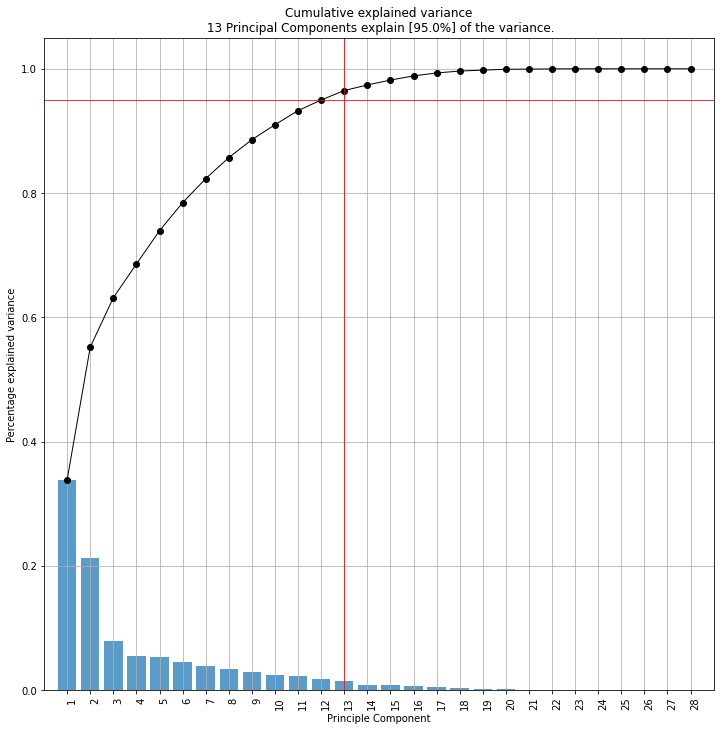

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 13 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [38]:
# initialize
pca_model = pca(random_state=42)

# Fit transform
results = pca_model.fit_transform(data_scaled)

# visualize
pca_model.plot(figsize=(12, 12))

Based upon the visual inspection, 13 features will get us around 95% variance. This would reduce our total features from 28 -> 13 or 53%.

In [39]:
# get columns 
pca_result_cols = list(results['topfeat'].iloc[0:13]['feature'].unique())

# get top n principals
explained_var = results['explained_var'][0:13]

# calculate contribution
xdiff = [explained_var[n]-explained_var[n-1] for n in range(1,len(explained_var))]
explained_contri = []
explained_contri.append(explained_var[0])
explained_contri = explained_contri + xdiff

# create summary df
results_df = results['topfeat'].iloc[0:13]
summary_df = results_df.copy()
summary_df.loc[:,'percentage'] = explained_var
summary_df.loc[:,'explained_var'] = explained_contri
summary_df

,PC,feature,loading,type,percentage,explained_var
0,PC1,totalYards,0.306063,best,0.338793,0.338793
1,PC2,rushingYards,0.385315,best,0.552128,0.213334
2,PC3,passingYardsAtCatch,0.531049,best,0.631464,0.079336
3,PC4,totalOffensivePlays,-0.494666,best,0.685913,0.054449
4,PC5,passingFumblesLost,0.567058,best,0.739338,0.053425
5,PC6,rushingFumblesLost,0.488648,best,0.784485,0.045147
6,PC7,totalPenalties,0.679243,best,0.823236,0.038751
7,PC8,totalTwoPointConvs,0.762935,best,0.857065,0.033829
8,PC9,totalTackles,-0.630542,best,0.885902,0.028837
9,PC10,totalTackles,-0.480449,best,0.909975,0.024073


The first 2 principals (totalYards amd rushingYards) accounts for approximately %55 of the variance. This leaves roughly %40 of the variance for the remaining 11 features.

### Reduce dataframes

In [40]:
pca_cols = list(summary_df['feature'].unique())

# reduce scaled df
data_scaled_pca = data_scaled[pca_cols].copy()

# reduce original df
wanted_features = pca_cols.copy()
wanted_features.append('team')
wanted_features.append('superbowl_win')

stats_pca = stats_updated[wanted_features].copy()

print(data_scaled_pca.shape)
print(stats_pca.shape)

(670, 12)
(670, 14)


## EDA section

In [41]:
stats_pca.describe()

,totalYards,rushingYards,passingYardsAtCatch,totalOffensivePlays,passingFumblesLost,rushingFumblesLost,totalPenalties,totalTwoPointConvs,totalTackles,totalKickingPoints,rushingBigPlays,passingBigPlays,superbowl_win
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,5617.222388,1823.865672,2555.834328,1012.907463,2.959701,3.588060,101.777612,1.150746,1041.820896,111.123881,10.589552,47.102985,0.031343
std,607.029051,337.218948,759.800555,46.956684,1.963764,2.040071,16.471557,1.270438,99.956796,19.329907,4.614290,10.784331,0.174374
min,3813.000000,1062.000000,1267.000000,859.000000,0.000000,0.000000,55.000000,0.000000,620.000000,57.000000,0.000000,21.000000,0.000000
25%,5223.250000,1596.250000,2008.750000,982.250000,2.000000,2.000000,91.000000,0.000000,1003.250000,99.000000,7.000000,39.250000,0.000000
50%,5616.500000,1788.000000,2342.500000,1015.000000,3.000000,3.000000,102.000000,1.000000,1048.000000,110.000000,10.000000,46.000000,0.000000
75%,6041.000000,2018.750000,3003.250000,1042.000000,4.000000,5.000000,112.000000,2.000000,1102.000000,125.000000,13.000000,54.000000,0.000000
max,7632.000000,3296.000000,5492.000000,1191.000000,10.000000,12.000000,163.000000,8.000000,1337.000000,168.000000,33.000000,82.000000,1.000000


### Profile

In [ ]:
# run to view EDA report 
profile = ProfileReport(stats_pca)
profile.to_file("project_analysis.html")
profile

## Prediction time

In [42]:
X = data_scaled_pca.values
y = stats_updated.loc[:,'superbowl_win'].values
org_classes = Counter(y)
org_classes

Counter({0.0: 649, 1.0: 21})

There's a clear imbalnce of classes. We will first need to take care of this before training a model. 

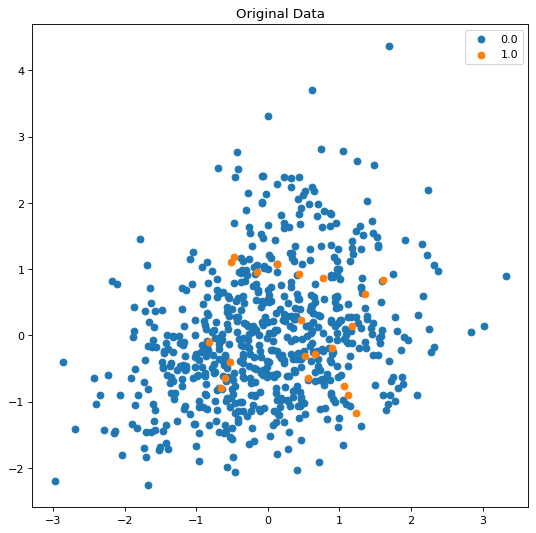

In [43]:
get_class_scatter(org_classes, 'Original Data')

### Random over and under sampling
We are going to use Random over and under sampling to augment the data.  Random oversampling works by picking samples at random with replacement of the minority class. RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the majority class.

In [44]:
# fit and apply the transform
over = RandomOverSampler(sampling_strategy=0.20, random_state=42)
X, y = over.fit_resample(X, y)
over_samp_classes = Counter(y)
over_samp_classes

Counter({0.0: 649, 1.0: 129})

In [45]:
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# fit and apply the transform
X, y = under.fit_resample(X, y)
under_samp_classes = Counter(y)
under_samp_classes

Counter({0.0: 258, 1.0: 129})

Using over and under sampling techniques, we increased our minority class 514% and reduced our majority class 60%. This should help make better models. 

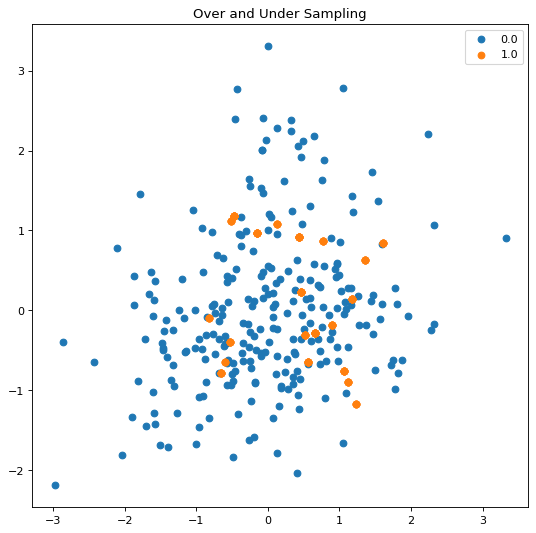

In [46]:
get_class_scatter(under_samp_classes, 'Over and Under Sampling')

### train, test, split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state=42)

### Logistic Regression

In [48]:
# first let's see what the optimal hyper params are

tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100], 'penalty':['l1','l2'], 'class_weight':[None, 'balanced']}
clf = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, cv=10, scoring="accuracy")
clf.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.5, 'class_weight': None, 'penalty': 'l1'}
accuracy : 0.7637634408602151


In [51]:
# now we'll create the model
logreg = LogisticRegression(class_weight='balanced',C=0.5, solver='liblinear', random_state=42)

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
logreg.fit(X_train, y_train)
n_scores = cross_val_score(logreg, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.754 (0.074)


In [52]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81        53
         1.0       0.60      0.84      0.70        25

    accuracy                           0.77        78
   macro avg       0.75      0.79      0.76        78
weighted avg       0.81      0.77      0.78        78



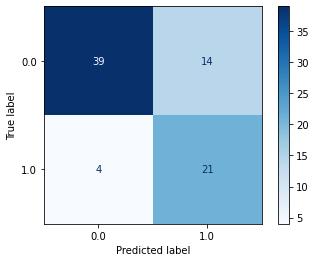

In [53]:
get_confusion_matrix(logreg, y_test)

0.7879245283018869


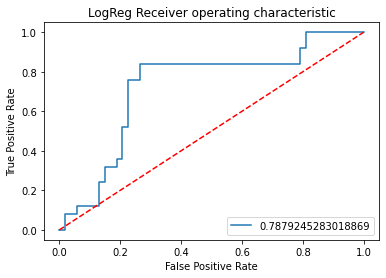

In [54]:
get_roc_graph(logreg, X_test, y_test, 'LogReg')

In [57]:
# save_model(logreg, 'logreg')

logreg model saved


The LogReg roc graph still indicates an inbalanced dataset.

### RandomeForest

In [55]:
# define the model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.982 (0.026)


In [56]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        53
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



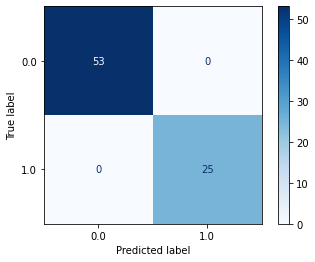

In [57]:
get_confusion_matrix(rf_model, y_test)

1.0


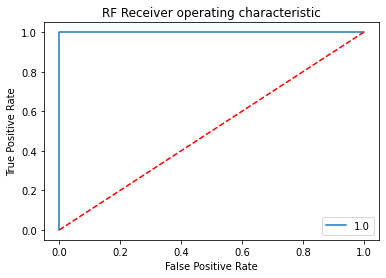

In [58]:
get_roc_graph(rf_model, X_test, y_test, 'RF')

In [59]:
# save_model(rf_model, 'rf')

rf model saved


The RandomForest classifier has a near perfect performance. This is troublesome and probably too good to be true. Possibly an indication of overfitting the training data. 

## Test predictions

In [63]:
def get_predictions(model, data, colnms):
    
    data = data.copy()
    
    years = data['year'].values
    teams = data['team'].values
    
    data_scaled = pd.DataFrame(preprocessing.scale(data[colnms].iloc[:, 0:12]),columns = colnms).copy()
    data_scaled.loc[:,'team'] = data['team'].values
    data_scaled.loc[:,'year'] = years
    data_scaled = data_scaled.fillna(0)
    
    data_scaled.loc[:,'prediction'] = model.predict_proba(data_scaled.iloc[:,0:12].values)[:, 1]
    data_year = data_scaled[['team','year','prediction']]
    
    display(data_year.sort_values(by=['prediction'], ascending=False))

In [64]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

dropdown_state = widgets.Dropdown(options = unique_sorted_values_plus_ALL(testing_df["year"]), description='Year: ')

output_predict = widgets.Output()

def event_action():
    # clear the previous selection on each iteration
    output_predict.clear_output()
    
    if (dropdown_state.value == ALL):
        common_filter = testing_df
        common_filter = common_filter[pca_cols].copy()
    
    else:
        common_filter = testing_df.loc[testing_df['year']==dropdown_state.value]
        
        with output_predict:
            get_predictions(logreg, common_filter, pca_cols)


def dropdown_state_eventhandler(change):
    event_action()
    

dropdown_state.observe(dropdown_state_eventhandler, names='value')

In [65]:
input_widgets = widgets.HBox([dropdown_state])

tab = widgets.Tab([output_predict])
tab.set_title(0, 'Prediction')

dashboard = widgets.VBox([tab], layout=Layout(height='400px'))
display(input_widgets, dashboard)